In [1]:
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout
import mdtraj as md
import matplotlib.pyplot as plt

In [2]:
pdb = PDBFile('water512.pdb')
forcefield = ForceField('spce.xml')
system = forcefield.createSystem(pdb.topology, nonbondedMethod=PME, nonbondedCutoff=1*nanometer, constraints=HBonds)
#integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)
integrator = NoseHooverIntegrator(300*kelvin, 1/picosecond, 0.005*picoseconds, 4, 1, 1)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy()
state = simulation.context.getState(getPositions=True, getVelocities=True, getEnergy=True, getForces=True, getParameters=True, enforcePeriodicBox=True)

# Extract the box vectors
box_vectors = state.getPeriodicBoxVectors()
print("Box Vectors:")
print(box_vectors)

# Retrieve and print the starting coordinates
state = simulation.context.getState(getPositions=True)
positions = state.getPositions()

print("Starting coordinates:")
for i, pos in enumerate(positions):
    print(f"Particle {i}: {pos}")

# Optionally, you can save the starting coordinates to a file for further inspection
with open("starting_coordinates.txt", "w") as f:
    for i, pos in enumerate(positions):
        f.write(f"Particle {i}: {pos}\n")

simulation.reporters.append(DCDReporter('output.dcd', 1000))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, potentialEnergy=True, temperature=True))
#simulation.reporters.append(ForceReporter('forces.txt', 1000))
simulation.step(10000)

Box Vectors:
[Vec3(x=2.5022, y=0.0, z=0.0), Vec3(x=0.0, y=2.5022, z=0.0), Vec3(x=0.0, y=0.0, z=2.5022)] nm
Starting coordinates:
Particle 0: Vec3(x=-0.3014926544769845, y=-0.08573814469993364, z=3.1865151669439875) nm
Particle 1: Vec3(x=-0.22572442913326984, y=-0.09562038099753559, z=3.2510249935756383) nm
Particle 2: Vec3(x=-0.269921877999679, y=-0.10819641409251364, z=3.0943256203211003) nm
Particle 3: Vec3(x=-0.3555479461699015, y=-0.03486627881839779, z=0.11339575000418031) nm
Particle 4: Vec3(x=-0.38592523547706853, y=0.016672194237979332, z=0.19352693237027918) nm
Particle 5: Vec3(x=-0.3201100447622778, y=0.028403710741775383, z=0.04454036631559465) nm
Particle 6: Vec3(x=3.247533673737283, y=-0.0958840746539052, z=0.6322914912131802) nm
Particle 7: Vec3(x=3.2491058057403572, y=0.0019987950240473217, z=0.6118838327831422) nm
Particle 8: Vec3(x=3.2050179096485136, y=-0.14509189175564968, z=0.5563243875560538) nm
Particle 9: Vec3(x=-0.18005950171720314, y=3.0789352635019935, z=1.000

In [3]:
# Print system characteristics
def print_system_info(system):
    print("Number of particles:", system.getNumParticles())
    print("Number of constraints:", system.getNumConstraints())
    print("Number of forces:", system.getNumForces())

    for i in range(system.getNumForces()):
        force = system.getForce(i)
        print(f"\nForce {i}: {type(force).__name__}")
        
        if isinstance(force, CustomNonbondedForce):
            print("  Energy function:", force.getEnergyFunction())
            print("  Number of particles:", force.getNumParticles())
            print("  Number of exclusions:", force.getNumExclusions())
            print("  Nonbonded method:", force.getNonbondedMethod())
            print("  Cutoff distance (nm):", force.getCutoffDistance().value_in_unit(nanometers))
            for j in range(force.getNumTabulatedFunctions()):
                func = force.getTabulatedFunction(j)
                print(f"  Tabulated function {j}: {type(func).__name__}")

# Call the function to print the system info
print_system_info(system)

Number of particles: 1536
Number of constraints: 1536
Number of forces: 4

Force 0: HarmonicBondForce

Force 1: NonbondedForce

Force 2: CMMotionRemover

Force 3: HarmonicAngleForce


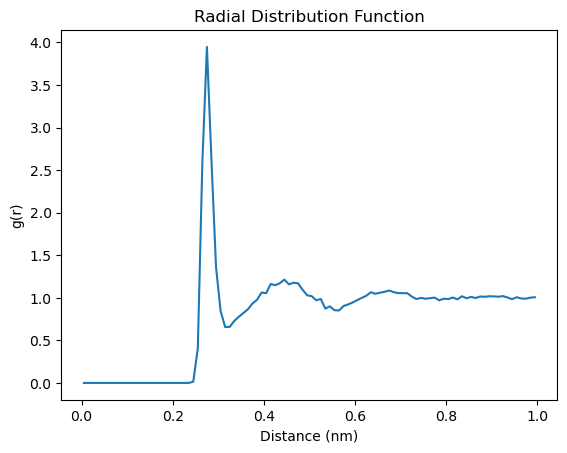

In [4]:
# Load the trajectory
traj = md.load('output.dcd', top='water512.pdb')

# Define atom pairs for which to compute the RDF (all the CG beads here)
oxygen_atoms = traj.topology.select('name O')

# Compute RDF
rdf, r = md.compute_rdf(traj, pairs=traj.topology.select_pairs(oxygen_atoms, oxygen_atoms), r_range=(0.0, 1.0), bin_width=0.01)

# Plot RDF
plt.plot(rdf, r)
plt.xlabel('Distance (nm)')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function')
plt.show()